# Importaciones

In [213]:
"""Módulo para crear un modelo predictivo de precios de Airbnb en la Comunidad de Madrid."""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# Descargar los datos

In [153]:
#!wget https://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2024-03-22/data/listings.csv.gz

In [154]:
# Reasoning behind which columns are removed, and which require text processing
columns = [
    'id',                     # Remove - Identifier
    'listing_url',            # Remove - URL with ID at end
    'scrape_id',              # Remove - details of scrape
    'last_scraped',           # Remove - detail of scrape
    'source',                 # Remove - detail of scrape
    'name',                   # Do text processing
    'description',            # Do text processing
    'neighborhood_overview',  # Do text processing
    'picture_url',            # Remove - URl
    'host_id',                # Could learn relation between host and price
    'host_url',               # Remove - redundant with host_id
    'host_name',              # Do text processing
    'host_since',             # Convert to number of months or years 
    'host_location',          # Do text processing
    'host_about',             # Do text processing
    'host_response_time', 'host_response_rate',
    'host_acceptance_rate', 'host_is_superhost',
    'host_thumbnail_url',     # Remove
    'host_picture_url',       # Remove
    'host_neighbourhood',     # Do text processing
    'host_listings_count', 'host_total_listings_count',
    'host_verifications',     #
    'host_has_profile_pic', 'host_identity_verified',
    'neighbourhood',          #  Remove - redundant
    'neighbourhood_cleansed', #  Do text processing
    'neighbourhood_group_cleansed',
    'latitude', 'longitude',  # Consider removing, redundant with neighbourhood_cleansed
    'property_type',          #  Do text processing
    'room_type', 'accommodates', 'bathrooms',
    'bathrooms_text',         # Remove - largely redundant
    'bedrooms', 'beds', 'amenities',
    'price',                  # Dependent variable
    'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
    'maximum_minimum_nights', 'minimum_maximum_nights',
    'maximum_maximum_nights', 'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm',
    'calendar_updated',       # Remove - 0 not null
    'has_availability',
    'availability_30', 'availability_60', 'availability_90',
    'availability_365',
    'calendar_last_scraped',  # Remove - same across all rows
    'number_of_reviews',
    'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'first_review', 'last_review',  # Convert to days ago
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value',
    'license',                # Remove 
    'instant_bookable',
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'reviews_per_month'   
]

data_types = {
    'price': pd.StringDtype(),
    'host_response_time': pd.StringDtype(),
    'host_response_rate': pd.StringDtype(),
    'host_acceptance_rate': pd.StringDtype(),
    'host_is_superhost': pd.StringDtype(),
    'host_has_profile_pic': pd.StringDtype(),
    'host_identity_verified': pd.StringDtype(),
    'room_type': pd.StringDtype(),
    'has_availability': pd.StringDtype(),
    'instant_bookable': pd.StringDtype(),
    'name': pd.StringDtype(),
    'description': pd.StringDtype(),
    'neighborhood_overview': pd.StringDtype(),
    'host_name': pd.StringDtype(),
    'host_location': pd.StringDtype(),
    'host_about': pd.StringDtype(),
    'host_neighbourhood': pd.StringDtype(),
    'neighbourhood_cleansed': pd.StringDtype(),
    'neighbourhood_group_cleansed': pd.StringDtype(),
    'property_type': pd.StringDtype(),
    'host_verifications': pd.StringDtype(),
    'amenities': pd.StringDtype(),
}

# Cargar los datos y crear subconjuntos

In [155]:
parse_dates = ['host_since','first_review','last_review']

data = pd.read_csv('listings.csv.gz', parse_dates=parse_dates, dtype=data_types)

# Select only data where there exists a price
data = data[data['price'].notnull()]
data.shape

(20688, 75)

In [156]:
data['price'].isnull().values.any()

False

In [157]:
cols_of_interest = [
    'price', 'host_id', 'host_since', 'host_response_time', 'host_response_rate',
    'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
    'host_total_listings_count', 'host_verifications', 'host_has_profile_pic',
    'host_identity_verified', 'latitude', 'longitude', 'room_type', 'accommodates',
    'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
    'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
    'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
    'has_availability', 'availability_30', 'availability_60', 'availability_90',
    'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value', 'instant_bookable',
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
    'reviews_per_month'
                   ]

In [158]:
# Columns to that require text processing
cols_text = [
    'name', 'description', 'neighborhood_overview', 'host_name', 
    'host_location', 'host_about', 'host_neighbourhood', 'neighbourhood_cleansed',
    'neighbourhood_group_cleansed', 'property_type', 'amenities'
            ]

In [159]:
# Create data subsets
data_numerical = data[cols_of_interest]
data_text = data[cols_text]

data_numerical.shape, data_text.shape

((20688, 50), (20688, 11))

# Ingeniería de Características

## Cleaning numerical columns

In [160]:
# COLS FOR LATER
# 'amenities'            # list of strings lalala
pd.options.mode.copy_on_write = True

### Clean price

In [161]:
data_numerical['price'] =  data_numerical['price'].replace({"[\$,)]":"",",":""}, regex=True).apply(pd.to_numeric)
y = data_numerical['price']
data_numerical = data_numerical.drop(['price'], axis=1)

### Calculate date columns as years

In [162]:
# Calculate years hosting
data_numerical['host_since_year'] = data_numerical['host_since'].apply(lambda x: x.year)
data_numerical['host_years'] = data_numerical['host_since_year'].apply(lambda x: 2024.0 - x)
data_numerical = data_numerical.drop(['host_since', 'host_since_year'], axis=1)

# Calculate years since first review
data_numerical['first_review_year'] = data_numerical['first_review'].apply(lambda x: x.year)
data_numerical['first_review_age'] = data_numerical['first_review_year'].apply(lambda x: 2024.0 - x)
data_numerical = data_numerical.drop(['first_review', 'first_review_year'], axis=1)

# Calculate years since last review
data_numerical['last_review_year'] = data_numerical['last_review'].apply(lambda x: x.year)
data_numerical['last_review_age'] = data_numerical['last_review_year'].apply(lambda x: 2024.0 - x)
data_numerical = data_numerical.drop(['last_review', 'last_review_year'], axis=1)

### Convert t/f columns to 1/0

In [163]:
# Change t f columns to 1 and 0
columns_t_f = ['host_is_superhost','host_has_profile_pic', 'host_identity_verified','has_availability','instant_bookable']
t_f = {'t':'1', 'f':'0'}

for col in columns_t_f:
    data_numerical[col] = data_numerical[col].replace(t_f)

data_numerical[columns_t_f] = data_numerical[columns_t_f].apply(pd.to_numeric)

### Convert rate columns to numerical

In [164]:
# Strip % and convert int
columns_percent = ['host_response_rate','host_acceptance_rate']

for col in columns_percent:
    data_numerical[col] = data_numerical[col].str.replace('%', '').apply(pd.to_numeric)

### Transform nominal variables using one hot encoding

In [165]:
# Clean string
data_numerical['host_verifications'] = data_numerical['host_verifications'].str.replace(r"[\'\[\]]", "", regex=True)
data_numerical['host_verifications'] = data_numerical['host_verifications'].str.replace(" ", "")

verification_cols = ['email_verified', 'phone_verified','work_email_verified']

# Expand columns
data_numerical[verification_cols] = data_numerical['host_verifications'].str.split(',', expand=True)

# Convert to 1 and 0
data_numerical[verification_cols] = data_numerical[verification_cols].notnull().astype(float)

# Drop original column
data_numerical = data_numerical.drop(['host_verifications'], axis=1)

In [166]:
# Transform categorical columns using one hot encoding
columns_categorical = ['host_response_time', 'room_type']

data_numerical = pd.get_dummies(data_numerical, columns=columns_categorical)

# Fill na with temporary placeholder
#placeholder = 'missing'
#data_numerical[columns_categorical] = data_numerical[columns_categorical].fillna(placeholder)

# Encode categories
#label_encoder = LabelEncoder()
#data_numerical['host_response_time_coded'] = label_encoder.fit_transform(data_numerical['host_response_time'])
#data_numerical['room_type_coded'] = label_encoder.fit_transform(data_numerical['room_type'])

# Drop original columns
#data_numerical = data_numerical.drop(columns_categorical, axis=1)

# Data exploration

In [167]:
data_numerical.columns

Index(['host_id', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_ent

## Final data transformations

In [168]:
# Handle Nulls usint interpolate
for col in data_numerical.columns:
    if data_numerical.isnull().values.any():
        data_numerical[col] = data_numerical[col].astype(float)
        data_numerical[col] = data_numerical[col].interpolate(method='linear')

In [169]:
# Normalize data using min-max normalization
normalized_numerical_data = (data_numerical-data_numerical.min())/(data_numerical.max()-data_numerical.min())

# Model Training

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [171]:
X_train, X_test, y_train, y_test = train_test_split(
    normalized_numerical_data, y, test_size=0.33, random_state=42)

In [183]:
#np.random.seed(42)
#from sklearn import linear_model
#br = linear_model.BayesianRidge()

def evaluate(model, test_features, test_labels):
    """
    Function to print model performance metrics.
    """
    pred = model.predict(test_features)
    mse =  metrics.mean_squared_error(test_labels, pred)
    mae = metrics.mean_absolute_error(test_labels, pred)
    rmse = np.sqrt(metrics.mean_squared_error(test_labels, pred))
    mape = np.mean(np.abs((test_labels - pred) / np.abs(test_labels)))
    
    print('-----Model Performance-----')
    print(f"Mean Absolute Error (MAE): {round(mae, 2)}")
    print(f"Mean Squared Error (MSE): {round(mse, 2)}")
    print(f"Root Mean Squared Error (RMSE): {round(rmse, 2)}")
    print(f"Mean Absolute Percentage Error (MAPE): {round(mape * 100, 2)}")
    print(f"Accuracy: {round(100*(1 - mape), 2)}")

    return

## Random Forest Regressor

### Baseline Results

In [175]:
# Baseline
base_model = RandomForestRegressor(random_state=42)
base_model.fit(X_train, y_train)

# Save model
joblib.dump(base_model, 'base_model.pkl', compress=True)

['base_model.pkl']

In [184]:
evaluate(base_model, X_test, y_test)

-----Model Performance-----
Mean Absolute Error (MAE): 58.49
Mean Squared Error (MSE): 68230.27
Root Mean Squared Error (RMSE): 261.21
Mean Absolute Percentage Error (MAPE): 55.21
Accuracy: 44.79


### Hyperparameter Tuning

In [ ]:
# Instantiate model
model = RandomForestRegressor(random_state=42)

# Dictionary of hyperparameters
parameters = {
    'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],
    'max_features':['sqrt', 'log2', None],
    'random_state':[42],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    #'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
}

# Hyperparameter tuning, automatically does 5-fold cv
cv = GridSearchCV(model, parameters, n_jobs=-1, verbose=10)
cv.fit(X_train, y_train)

# Pickle model
joblib.dump(cv, 'cv.pkl', compress=True)
joblib.dump(cv.best_estimator_, 'cv_best_model.pkl')

In [ ]:
cv_best_model = joblib.load('cv_best_model.pkl')
cv = joblib.load('cv.pkl')

### Final Results

In [187]:
cv_best_model = cv.best_estimator_
evaluate(cv_best_model, X_test, y_test)

-----Model Performance-----
Mean Absolute Error (MAE): 52.38
Mean Squared Error (MSE): 44024.43
Root Mean Squared Error (RMSE): 209.82
Mean Absolute Percentage Error (MAPE): 49.79
Accuracy: 50.21


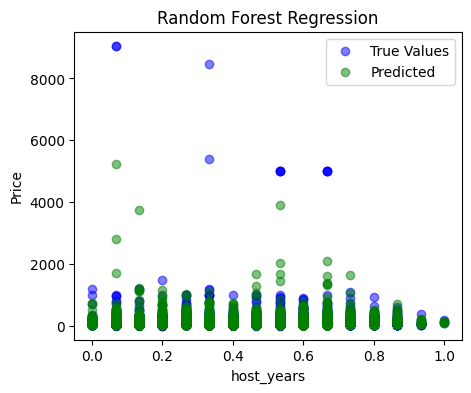

In [209]:
pred = cv_best_model.predict(X_test)
variable_of_interest = 'host_years'

fig, ax = plt.subplots(figsize=(5,4))

ax.scatter(X_test[variable_of_interest].values, y_test, color='blue', alpha=.5)
ax.scatter(X_test[variable_of_interest].values, pred, color='green', alpha=.5)
ax.set_title('Random Forest Regression')
ax.set_xlabel(variable_of_interest)
ax.set_ylabel('Price')
ax.legend(["True Values", "Predicted"])
plt.show()

## Ridge Regressor

### Baseline

In [217]:
# Get baseline
base_gradboost = HistGradientBoostingRegressor(random_state=42)
base_gradboost.fit(X_train, y_train)

# Save model
joblib.dump(base_gradboost, 'base_gradboost_model.pkl', compress=True)

['base_gradboost_model.pkl']

In [218]:
evaluate(base_gradboost, X_test, y_test)

-----Model Performance-----
Mean Absolute Error (MAE): 60.84
Mean Squared Error (MSE): 59387.45
Root Mean Squared Error (RMSE): 243.7
Mean Absolute Percentage Error (MAPE): 60.65
Accuracy: 39.35


### Hyperparameter Tuning